In [2]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np  

In [3]:
data=pd.read_csv('TaxiDataCleaned.csv')

In [37]:
categorical = ['pickup_community_area', 'trip_start_month', 'trip_start_hour', 'trip_start_day', 'dropoff_community_area', 'payment_type', 'company']
numerical = ['trip_start_timestamp', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'trip_miles', 'fare', 'trip_seconds', 'tips']
for col in categorical:
    data[col] = data[col].astype('category')
for col in ['pickup_community_area', 'dropoff_community_area']:
    data[col] = data[col].astype('int')

<Axes: xlabel='payment_type', ylabel='tips'>

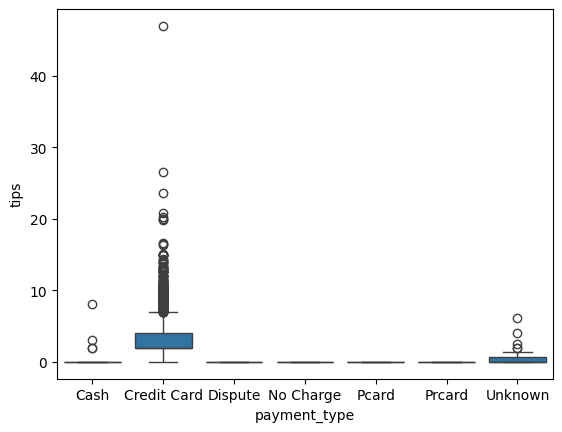

In [38]:
sns.boxplot(x=data['payment_type'], y=data['tips'])

There is one huge outlier in the fares, with a value around 700.7, and another outlier with a value around 200. Outliers are generally concentrated in credit card payments, which has high variance, suggesting 

In [39]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [40]:
x_train, x_test, y_train, y_test = train_test_split(data[['trip_miles','trip_seconds','pickup_community_area','dropoff_community_area']], data['tips'], test_size=0.2, random_state=42)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    cv_results[name] = -scores.mean()  # Convert to positive RMSE

best_model_name = min(cv_results, key=cv_results.get)
best_model = models[best_model_name]

print("Cross-Validation Results (Average RMSE):")
for name, rmse in cv_results.items():
    print(f"{name}: {rmse:.4f}")
print(f"\nBest Model: {best_model_name} with RMSE = {cv_results[best_model_name]:.4f}")

best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
y_pred=[0 if i<0 else i for i in y_pred]
rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nTest RMSE for Best Model ({best_model_name}): {rmse:.4f}")

Cross-Validation Results (Average RMSE):
Linear Regression: 2.1854
Random Forest: 1.9849
Gradient Boosting: 1.8480
AdaBoost: 1.9585

Best Model: Gradient Boosting with RMSE = 1.8480

Test RMSE for Best Model (Gradient Boosting): 1.8800


The model is pretty accurate, yielding a RMSE of just 1.88 Dollars when the standard deviation is almost 11.

Potential limitations include the fact that for a lot of possible pickup and drop locations, there is very little data (only 2-3 taxi rides worth of data, making it hard to regress on them). I thought one optimization would be to explicitly consider certain data as categorical, and tested this by importing a regressor suited to categorical data, but that did not give any significant improvement, possibly due to the limitation mentioned above.

Another limitation is that there are a few extreme outliers in the fare data, which can skew the results of a model which overfits to these outliers, especially the outliers where the fare paid exceeded 700 USD.

In [42]:
from catboost import CatBoostRegressor

In [43]:
model=CatBoostRegressor(cat_features=[2,3], loss_function='RMSE')

In [44]:
model.fit(x_train, y_train)

Learning rate set to 0.060631
0:	learn: 2.1181597	total: 51.9ms	remaining: 51.9s
1:	learn: 2.0914550	total: 55ms	remaining: 27.5s
2:	learn: 2.0675866	total: 57.7ms	remaining: 19.2s
3:	learn: 2.0458431	total: 60.2ms	remaining: 15s
4:	learn: 2.0264583	total: 62.8ms	remaining: 12.5s
5:	learn: 2.0087722	total: 65.2ms	remaining: 10.8s
6:	learn: 1.9923180	total: 67.6ms	remaining: 9.58s
7:	learn: 1.9785125	total: 69.9ms	remaining: 8.66s
8:	learn: 1.9636208	total: 72.3ms	remaining: 7.96s
9:	learn: 1.9508110	total: 74.5ms	remaining: 7.37s
10:	learn: 1.9393222	total: 76.4ms	remaining: 6.87s
11:	learn: 1.9289131	total: 78.5ms	remaining: 6.46s
12:	learn: 1.9180735	total: 80.5ms	remaining: 6.11s
13:	learn: 1.9092399	total: 81.6ms	remaining: 5.75s
14:	learn: 1.8994827	total: 83.3ms	remaining: 5.47s
15:	learn: 1.8924545	total: 84.8ms	remaining: 5.21s
16:	learn: 1.8849776	total: 86.9ms	remaining: 5.02s
17:	learn: 1.8786190	total: 89ms	remaining: 4.85s
18:	learn: 1.8724949	total: 90.9ms	remaining: 4.69

In [45]:
root_mean_squared_error(y_test, model.predict(x_test))

1.8798666351328517